In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin

Populating the interactive namespace from numpy and matplotlib


B:\GitRepos\onhm-fetcher-parser\notebooks\EricM
..\..\RussianData


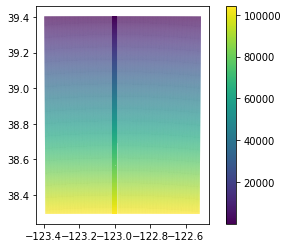

In [2]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../../RussianData') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
shapefiles = folder.glob("*geographic2.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(1, 1)
gdf.plot(column='HRU_ID', ax=ax, legend=True)
#print(gdf)

In [5]:
import requests
from requests.exceptions import HTTPError

# delete existing file if it exists
exists = os.path.isfile(r'../../RussianData/test3.nc')
if exists:
#     ds.close()
    os.remove(r'../../RussianData/test3.nc')
    print('removed existing file')
    
# example url
# http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2019-01-01T00%3A00%3A00Z&time_end=2019-01-01T00%3A00%3A00Z&timeStride=1&accept=netcdf
# Url for aggragated
url2 = 'http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc'
payload2={'var': 'daily_maximum_temperature',
        'disableLLSubset': 'on',
        'disableProjSubset': 'on',
        'horizStride': '1',
        'time_start': '2018-12-31T00:00:00Z',
        'time_end': '2018-12-31T00:00:00Z',
        'timeStride': '1',
        'accept': 'netcdf'}
# print(url)
try:
#     myfile = requests.get(url, params=payload)
    myfile = requests.get(url2, params=payload2)
    myfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')  # Python 3.6
except Exception as err:
    print(f'Other error occurred: {err}')  # Python 3.6
else:
    print('Success!')
#     print(myfile.headers)
    print(myfile.url)
        
with open(r'../../RussianData/test3.nc', 'wb') as fh:
    fh.write(myfile.content)
    fh.close()

ds = xr.open_dataset(r'../../RussianData/test3.nc')
print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
# datahandle=ds['air_temperature'] # for non aggragated download
datahandle=ds['daily_maximum_temperature'] # for aggragated download
# crshandle=ds['crs']
# print('\n The crs meta data is \n', json.dumps(crshandle.attrs, indent=4))

# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
# print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)

ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

removed existing file
Success!
http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00%3A00%3A00Z&time_end=2018-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf
<xarray.Dataset>
Dimensions:                    (day: 1, lat: 585, lon: 1386)
Coordinates:
  * day                        (day) datetime64[ns] 2018-12-31
  * lat                        (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
  * lon                        (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    daily_maximum_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.400000000000006
    geospatial_lon_min:         -1

   grid_ids  HRU_ID    w
0    370095  103731  1.0
1    370095  103732  1.0
2    370095  103733  1.0
3    370095  103734  1.0
4    370095  103735  1.0
[nan nan nan ... nan nan nan]
103983 103983
min/max 0.0 14.399993896484432


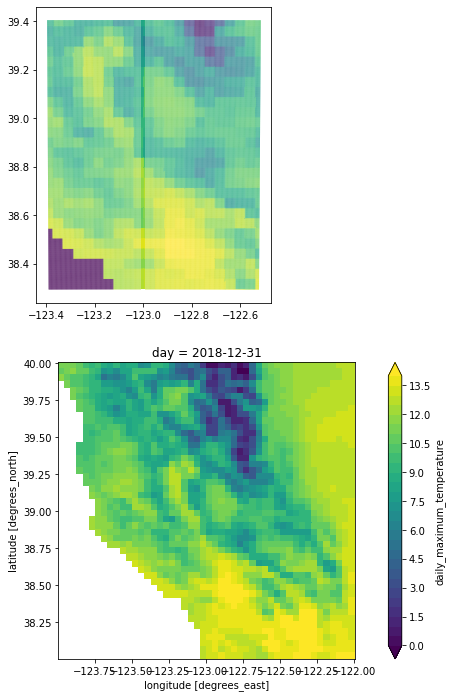

In [17]:
from numpy.ma import masked
# add tmax column to dataframe
gdf['tmax']=0.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('../../RussianData/Russian_weights_hru_v3b.csv')
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')

print(ndata[1000:])

unique_hru_ids = wght_UofI.groupby('HRU_ID')
print(len(gdf), len(unique_hru_ids))

def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
def np_get_wval(ndata, wghts, hru_id):
    """
    Returns weighted average of ndata with weights = grp
    1) mdata = the subset of values associated with the gridmet id's that are mapped to hru_id.
    2) Some of these values may have nans if the gridmet id is outside of conus so only return values
    that are inside of conus
    3) this means that hru's that are entirely outside of conus will return nans which will ultimately,
    outside of this function get assigned zero's.
    4) the value is assigned the weighted average
    :param ndata: float array of data values
    :param wghts: float array of weights
    :param hru_id hru id number
    :return: numpy weighted averaged - masked to deal with nans associated with
            ndata that is outside of the conus.
    """
    mdata = np.ma.masked_array(ndata[wghts['grid_ids'].values.astype(int)],
                               np.isnan(ndata[wghts['grid_ids'].values.astype(int)]))

    # mdata = np.ma.masked_where(ndata[wghts['grid_ids'].values.astype(int)] <= 0.0,
    #                            (ndata[wghts['grid_ids'].values.astype(int)]))
    tmp = np.ma.average(mdata, weights=wghts['w'])
    if tmp is masked:
        # print('returning masked value', hru_id, mdata, wghts['w'])
        return np.nan

    else:
        return tmp
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row['HRU_ID'])
#         td[index] = np_get_wval2(weight_id_rows, ndata) - 273.5
        td[index] = np.nan_to_num(np_get_wval(ndata, weight_id_rows, index+1) - 273.5)
    except KeyError:
        td[index] = 0.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td.tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())

f, ax = plt.subplots(2, figsize=(12,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
temp = ds.daily_maximum_temperature[0,:,:]
# print(temp)
# print(temp.lat)
delaware = temp.where((ds.lon>=-124) & (ds.lon<=-122) & (ds.lat>=38) & (ds.lat<=40), drop=True)-273.5
# print(delaware)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
p=delaware.plot(ax=ax[1], levels=lvs, cmap='viridis')
ax[1].set_aspect('equal','box')